# ECE 57000 Assignment 4 Exercise

Your Name: Jiayu Chen


## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.



In [1]:
import torch
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [2]:
import torch.nn as nn
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
cuda:0
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (30 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Following the structure used in the instructions, you should create

*   One network named **OurFC** which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named **OurCNN** which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions
* You are **required** to print out the loss in the training and loss+accuracy in the test as in the instructions.

In [11]:
# ----------- <Your code> ---------------
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class OurFC(nn.Module):

  def __init__(self):
    super(OurFC, self).__init__()

    self.fc_1 = nn.Linear(784, 392)
    # self.fc_2 = nn.Linear(392, 196)
    self.fc_3 = nn.Linear(392, 10)

  def forward(self, x):

    x = x.view(-1, 784)      # x now has shape (batchsize x 784 (28x28))
    x = F.relu(self.fc_1(x))    # x has shape (batchsize x 392)
    # x = F.relu(self.fc_2(x))
    x = F.relu(self.fc_3(x))
    return F.log_softmax(x,-1) 

class OurCNN(nn.Module):

  def __init__(self):
    super(OurCNN, self).__init__()

    self.conv = nn.Conv2d(1, 4, kernel_size=5)
    self.fc = nn.Linear(576, 10)

  def forward(self, x):

    x = self.conv(x)        
    x = F.relu(F.max_pool2d(x,2))  
    x = x.view(-1, 576)      # x now has shape (batchsize x 432)
    x = F.relu(self.fc(x))     # x has shape (batchsize x 10)
    return F.log_softmax(x,-1)


transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform)

# print(train_dataset)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

train_losses = []
train_counter = []
test_losses = []
test_counter = []

def train(classifier, epoch):

  classifier.train() # we need to set the mode for our model
  optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)
  for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(torch.device('cuda'))
    targets = targets.to(torch.device('cuda'))
    optimizer.zero_grad()
    output = classifier(images)
    loss = F.nll_loss(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')


def test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(torch.device('cuda'))
      targets = targets.to(torch.device('cuda'))
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

max_epoch = 2

print("################################################## The results of FC ##################################################")
classifier = OurFC()
classifier = classifier.to(torch.device('cuda'))
for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)

print("################################################## The results of CNN ##################################################")
classifier = OurCNN()
classifier = classifier.to(device)
for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)

################################################## The results of FC ##################################################
Epoch 1: [0/60000] Loss: 2.3337788581848145
Epoch 1: [6400/60000] Loss: 0.49273815751075745
Epoch 1: [12800/60000] Loss: 0.33432552218437195
Epoch 1: [19200/60000] Loss: 0.3104695975780487
Epoch 1: [25600/60000] Loss: 0.19725091755390167
Epoch 1: [32000/60000] Loss: 0.2321804165840149
Epoch 1: [38400/60000] Loss: 0.3687684237957001
Epoch 1: [44800/60000] Loss: 0.15072327852249146
Epoch 1: [51200/60000] Loss: 0.2244514673948288
Epoch 1: [57600/60000] Loss: 0.33083540201187134
Test result on epoch 1: Avg loss is 0.17709961318969727, Accuracy: 94.73999786376953%
Epoch 2: [0/60000] Loss: 0.17634814977645874
Epoch 2: [6400/60000] Loss: 0.16362150013446808
Epoch 2: [12800/60000] Loss: 0.1278969645500183
Epoch 2: [19200/60000] Loss: 0.20756062865257263
Epoch 2: [25600/60000] Loss: 0.2046758532524109
Epoch 2: [32000/60000] Loss: 0.15595221519470215
Epoch 2: [38400/60000] Loss

### Task 2: Compare the number of parameters that are used in both your neural networks by printing out the total number of parameters for both of your networks.

**Note:** You need to clearly show which number corresponds to which network.

In [12]:
# ----------- <Your code> ---------------
print("The number of parameters in FC: ", sum(x.numel() for x in OurFC().parameters()))
print("The number of parameters in CNN: ", sum(x.numel() for x in OurCNN().parameters()))

The number of parameters in FC:  311650
The number of parameters in CNN:  5874


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders and plot images
Set up a `train_loader` and `test_loader` for the CIFAR-10 data, and plot a figure:

*   3 x 3 subplot
*   each subplot is a randomly chosen image from the test dataset
*   label each image with its label

The corresponding names of the classes is given as 
`classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')`

Note: In your transforms, the normalizing constant is given as `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current batch index is 0
images has shape torch.Size([1000, 3, 32, 32])
targets has shape torch.Size([1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


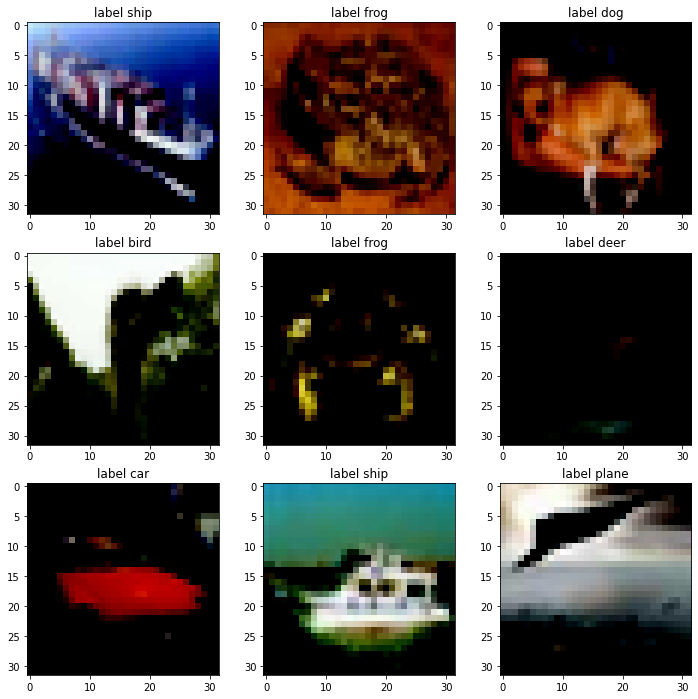

In [13]:
# ----------- <Your code> ---------------

import matplotlib.pyplot as plt
import random

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

batch_idx, (images, targets) = next(enumerate(test_loader))
print(f'current batch index is {batch_idx}')
print(f'images has shape {images.size()}')
print(f'targets has shape {targets.size()}')

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
for i in range(3):
  for j in range(3):
    idx = random.randint(0, batch_size_test-1)
    ax[i,j].imshow(images[idx].permute(1,2,0))
    ax[i,j].set_title(f'label {classes[targets[idx]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards:


*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [14]:
# ----------- <Your code> ---------------
# You should have your test accuracy printed in the output box
class NewCNN(nn.Module):

  def __init__(self):
    super(NewCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) 

  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

train_losses = []
train_counter = []
criterion = nn.CrossEntropyLoss()

def train(classifier, epoch):

  classifier.train() # we need to set the mode for our model
  optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
  for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(torch.device('cuda'))
    targets = targets.to(torch.device('cuda'))
    optimizer.zero_grad()
    output = classifier(images)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')


def test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model
  
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(torch.device('cuda'))
      targets = targets.to(torch.device('cuda'))
      output = classifier(images)
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples

  print(f'Accuracy: {100.*correct/len(test_loader.dataset)}%')

max_epoch = 10

print("################################################## The results of CNN on Cifar-10 ##################################################")
classifier = NewCNN()
classifier = classifier.to(device)
for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)

PATH = './cifar_net.pth'
torch.save(classifier.state_dict(), PATH)

################################################## The results of CNN on Cifar-10 ##################################################
Epoch 1: [0/50000] Loss: 2.3162803649902344
Epoch 1: [6400/50000] Loss: 2.322421073913574
Epoch 1: [12800/50000] Loss: 2.2975094318389893
Epoch 1: [19200/50000] Loss: 2.2969303131103516
Epoch 1: [25600/50000] Loss: 2.30129075050354
Epoch 1: [32000/50000] Loss: 2.2941319942474365
Epoch 1: [38400/50000] Loss: 2.296064853668213
Epoch 1: [44800/50000] Loss: 2.287224531173706
Accuracy: 15.129999160766602%
Epoch 2: [0/50000] Loss: 2.2963459491729736
Epoch 2: [6400/50000] Loss: 2.26577091217041
Epoch 2: [12800/50000] Loss: 2.2511937618255615
Epoch 2: [19200/50000] Loss: 2.187124490737915
Epoch 2: [25600/50000] Loss: 2.1305012702941895
Epoch 2: [32000/50000] Loss: 2.069594144821167
Epoch 2: [38400/50000] Loss: 1.997836709022522
Epoch 2: [44800/50000] Loss: 2.050309658050537
Accuracy: 28.939998626708984%
Epoch 3: [0/50000] Loss: 1.8565778732299805
Epoch 3: [6400/5

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


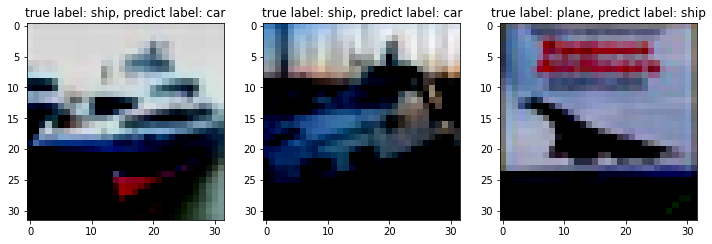

In [17]:
# ----------- <Your code> ---------------
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(1,3,figsize=(12,12))

PATH = './cifar_net.pth'
classifier.load_state_dict(torch.load(PATH))
num_fault = 0
with torch.no_grad():
  for images, targets in test_loader:
    images = images.to(torch.device('cuda'))
    targets = targets.to(torch.device('cuda'))
    output = classifier(images)
    pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
    for i in range(targets.shape[0]):
      if targets[i] != pred[i][0]:
        num_fault += 1
        ax[num_fault-1].imshow(images[i].cpu().permute(1,2,0))
        ax[num_fault-1].set_title(f'true label: {classes[targets[i]]}, predict label: {classes[pred[i][0]]}')
        if num_fault >= 3:
          break
    if num_fault >= 3:
      break

fig.show()



Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [18]:
# ----------- <Your code> ---------------
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

### Task2: Create data loaders for CIFAR-10

Then you need to create a dataloader of CIFAR-10. Note that the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width. See [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize).
You will probably want to add this transform appropriately to the `transform` you created in a previous task.


In [19]:
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224, 224)),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

batch_idx, (images, targets) = next(enumerate(test_loader))
print(f'current batch index is {batch_idx}')
print(f'images has shape {images.size()}')
print(f'targets has shape {targets.size()}')

Files already downloaded and verified
Files already downloaded and verified
current batch index is 0
images has shape torch.Size([1000, 3, 224, 224])
targets has shape torch.Size([1000])


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [20]:
# ----------- <Your code> ---------------

resnet18.cuda()
test(resnet18, 0)

Accuracy: 0.029999999329447746%


### Task 4: Update model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You should print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [25]:
# ----------- <Your code> ---------------
for name, param in resnet18.state_dict().items():
    # print(name)
    if 'fc' in name or 'layer4.1' in name:
      continue
    param.requires_grad = False

max_epoch = 2
for epoch in range(1, max_epoch+1):
  train(resnet18, epoch)
  test(resnet18, epoch)

Epoch 1: [0/50000] Loss: 2.3681211471557617
Epoch 1: [6400/50000] Loss: 0.801268458366394
Epoch 1: [12800/50000] Loss: 0.462134450674057
Epoch 1: [19200/50000] Loss: 0.2879837453365326
Epoch 1: [25600/50000] Loss: 0.3582305312156677
Epoch 1: [32000/50000] Loss: 0.24430212378501892
Epoch 1: [38400/50000] Loss: 0.3660908341407776
Epoch 1: [44800/50000] Loss: 0.26371821761131287
Accuracy: 91.77999877929688%
Epoch 2: [0/50000] Loss: 0.1872023046016693
Epoch 2: [6400/50000] Loss: 0.335410475730896
Epoch 2: [12800/50000] Loss: 0.06699049472808838
Epoch 2: [19200/50000] Loss: 0.10303964465856552
Epoch 2: [25600/50000] Loss: 0.45045527815818787
Epoch 2: [32000/50000] Loss: 0.1306433528661728
Epoch 2: [38400/50000] Loss: 0.2616821825504303
Epoch 2: [44800/50000] Loss: 0.13370847702026367
Accuracy: 93.04000091552734%
